# Case Study: Recent USGS Earthquakes

Here we will examine recent USGS earthquake data in order to demonstrate basic functionality of Pandas and a few other scientific python packages. We will primarily work on basic visualization and some contrived computations. 

The data were downloaded from the [USGS site](https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from mpl_toolkits.basemap import Basemap

PATH_TO_FILE = 'recent_earthquakes.csv'

## Data Exploration
First let's read the data into a pandas DataFrame, the main datatype used in Pandas. A dataframe is essentially a table (like in excel) which has rows and columns. 

In [2]:
df = pd.read_csv(PATH_TO_FILE)  # read data from a csv into a dataframe

In [3]:
df.head(3)  # list the first 3 rows

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2017-04-16T01:47:11.617Z,63.1496,-149.702500,86.10,2.30,ml,NaN,NaN,NaN,0.54,...,2017-04-16T01:59:50.471Z,"46km SW of Cantwell, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
1,2017-04-16T01:35:48.014Z,60.1571,-150.979100,34.10,2.20,ml,NaN,NaN,NaN,0.90,...,2017-04-16T01:40:36.725Z,"29km SE of Cohoe, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
2,2017-04-16T00:55:05.990Z,33.4795,-116.455333,7.48,0.97,ml,31.0,86.0,0.0503,0.21,...,2017-04-16T00:58:49.048Z,"22km ESE of Anza, CA",earthquake,0.3,0.79,0.196,26.0,automatic,ci,ci


In [4]:
print(df.columns)  # print the column names

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')


In [5]:
print(df.index)  # print the index
print(len(df))  # print the length (number of rows) of the dataframe

RangeIndex(start=0, stop=8949, step=1)
8949


### Column Selection
Data, stored as numpy arrays, from columns in a DataFrame can be accessed using the get item (df['item']) or the getattr (df.attr) interface. Be careful with the getattr interface, however, as there might be a conflict with the DataFrame attributes and a column name.

In [6]:
df.mag.equals(df['mag'])

True

The underlying datatypes in dataframes are numpy arrays, which can be accessed with the values attribute.

In [7]:
type(df.mag.values)

numpy.ndarray

### Filtering Rows
Let's work on plotting the EQs. Even though our dataset contains seismic events from all around the world, we are only interested in EQs occurring in the US, because 'Merica. Also, forget Alaska and Hawaii to make the plot easier. The first thing to do is filter the dataframe based on our spatial requirements. It will also be easier to plot if we only include events that have a magnitude greater than 1. Let's filter the dataframe based on those requirements.

In [8]:
# setup values to filter on
lat_min, lat_max = 20, 50
lon_min, lon_max = -126, -65
# create new dataframe object that is filtered
con1 = df.latitude >= lat_min
con2 = df.latitude <= lat_max
con3 = df.longitude >= lon_min
con4 = df.longitude <= lon_max
con5 = df.mag >= 1
df_filt = df[con1 & con2 & con3 & con4 & con5] 
# reset index
df_filt.reset_index(inplace=True, drop=True)
print(len(df_filt))

2029


Note how we used python's bitwise and (expressed with &) rather than the usual and. Likewise, we would need to use the bitwise or (|) and bitwise not (~) for doing this kind of Boolean indexing. 

### Make a Simple Map
Now that the data are filtered, let's plot the EQs. The matplotlib basemap toolkit is easy for making preliminary maps. 

C:\Users\Derrick\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Derrick\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


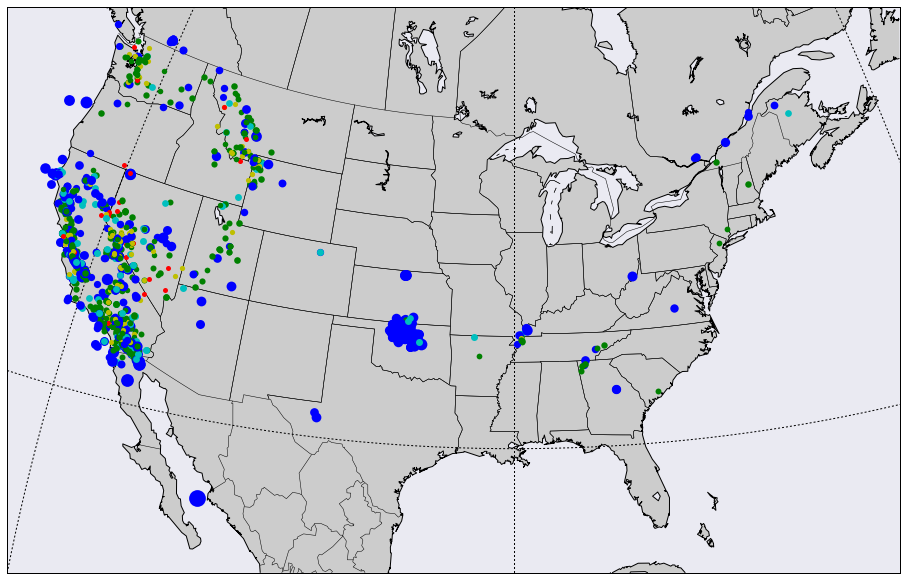

In [9]:
def get_marker_colors(df):
    """ add plot string to df by dividing magnitudes into 5 equal parts"""
    colors = ['r', 'y', 'g', 'c', 'b']
    div_incs = len(df) // 5 
    sorted_mags = df.mag.sort_values()
    division_points = [sorted_mags[x * div_incs] for x in range(1, 6)]
    # init array of zeros
    color = np.ones(len(df)) -1
    for lower in division_points[:-1]:
        color += df.mag > lower
    # map colors to list based on num of limits exceeded
    return [colors[int(x)] + 'o' for x in color]


def setup_map():
    """ function to setup basemap projection  and plot basic features """
    # Setup projection
    plt.figure(figsize=(16, 16))
    eq_map = Basemap(projection='tmerc', resolution = 'l', area_thresh = 1000.0,
                  lat_0=35, lon_0=-90, llcrnrlon=-120, llcrnrlat=20, urcrnrlon=-55.,
                     urcrnrlat=50.,)
    # draw countries and coasts
    eq_map.drawcoastlines()
    eq_map.drawcountries()
    eq_map.fillcontinents() #color='gray')
    eq_map.drawmapboundary()
    eq_map.drawstates()
    # draw ticks
    eq_map.drawmeridians(np.arange(0, 360, 30))
    eq_map.drawparallels(np.arange(-90, 90, 30))
    return eq_map

# get map objects
eq_map = setup_map()

# get x, y values in map projection
xs, ys = eq_map(df_filt.longitude.values, df_filt.latitude.values)

# get dot sizes
ms = (df_filt.mag.values + 1) * 2.5

# get colors
colors = get_marker_colors(df_filt)

# iter and plot (basemap only accepts one color at a time)
for x, y, m, c in zip(xs, ys, ms, colors):
    eq_map.plot(x, y, c, markersize=m)

plt.show()



### Plotting Histograms

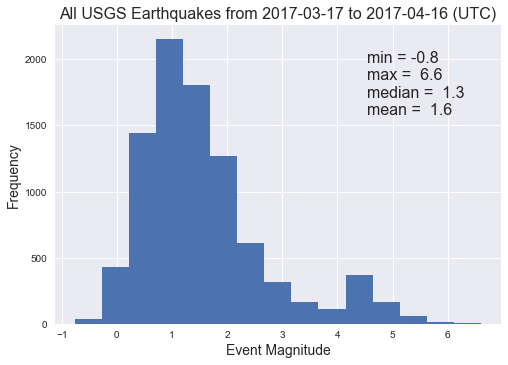

In [10]:
# print the magnitude distribution with basic stats
df.mag.hist(bins=15)  # plot a basic histogram of magnitudes (just calls plt.hist on data)
plt.xlabel('Event Magnitude', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# add title
min_date = df.time.min().split('T')[0]
max_date = df.time.max().split('T')[0]
title = f'All USGS Earthquakes from {min_date} to {max_date} (UTC)'
plt.title(title, fontsize=16)
# add stats in text box
text = (f'min = {df.mag.min(): .1f}\nmax = {df.mag.max(): .1f}\n'
        f'median = {df.mag.median(): .1f}\nmean = {df.mag.mean(): .1f}')
plt.annotate(text, xy=(.70, .70), xycoords='axes fraction', fontsize=16)
plt.show()

### Looking for Relationships
Often it is beneficial to look for relationships between variables in the data. If there are some columns we suspect may be related we can use seaborn's pairplot to quickly visually inspect column pairs and histograms.  

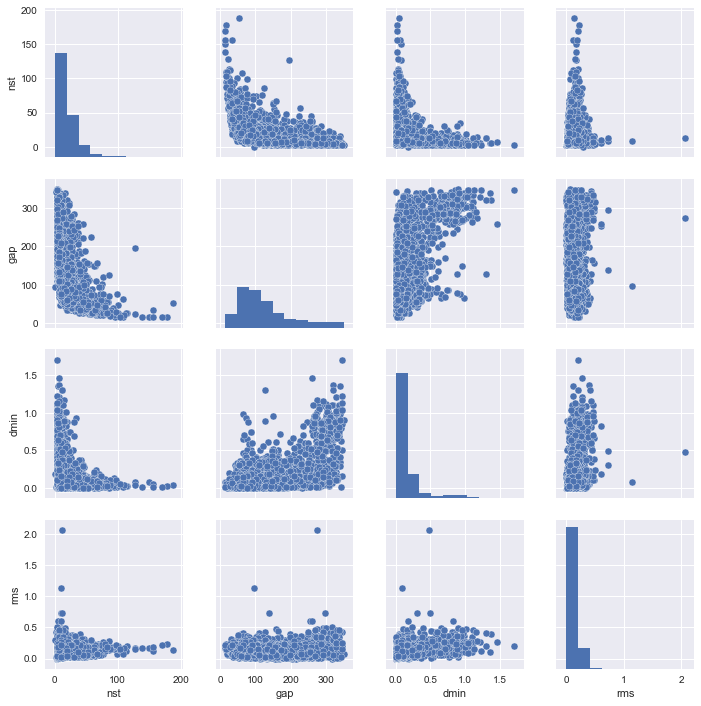

In [11]:
cols_to_check = ['nst', 'gap', 'dmin', 'rms']
df1 = df[cols_to_check]  # here we create a new dataframe, dropping all but selected columns
# we also need to remove any rows that have NaN values
df1 = df1[~df1.isnull().any(axis=1)]
sns.pairplot(df1)
plt.show()

### Quantifying the Extent of Missing Values
Let's try and figure out which columns have missing data (NaN values), then count how many missing values there are for each column.

In [12]:
df.isnull().any()

time               False
latitude           False
longitude          False
depth              False
mag                False
magType            False
nst                 True
gap                 True
dmin                True
rms                 True
net                False
id                 False
updated            False
place              False
type               False
horizontalError     True
depthError          True
magError            True
magNst              True
status             False
locationSource     False
magSource          False
dtype: bool

In [13]:
df.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                4273
gap                3447
dmin               3485
rms                  12
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    4350
depthError           12
magError           3599
magNst             3506
status                0
locationSource        0
magSource             0
dtype: int64

Now let's make the number of missing values a column in the dataframe and count the occurrence of each.

In [14]:
df['num_missing_values'] = df.isnull().sum(axis=1)  # use setitem to insert new column
df['num_missing_values'].value_counts()

0    3665
6    3422
1    1762
4      39
3      34
5      21
7       3
2       3
Name: num_missing_values, dtype: int64

Clearly we have a lot of data missing for some of the columns. Let's try to figure out if some networks are doing better than others at providing all the requested data. 

### The Blame Game
Let's figure out which networks are not providing data. We will do that by grouping the dataframe by network. Let's first make sure the locationSource (the network that provided the location) and magSource (the network that provided the magnitude), and the network are almost always the same.

In [15]:
# count how many times the location source and mag source are different
((df.net != df.locationSource) | (df.net != df.magSource)).sum()

97

Since the reported network, location providers, and magnitude providers are only different in about 1% of the cases, let's just assume they are always the same for this example. We want to collect stats on each of the networks to figure out who to blame for all the missing values, and see how each network is doing (on average) for the columns that reflect quality. We will be looking for the number of events provided, number of missing data for each column, the average of the quality columns.

First, a look at who is who (taken from [here](http://quake.geo.berkeley.edu/anss/anss-catalog-source-codes.html)):

|Code| Network Name and Operator |
| -- | ------------------------- |
| AK | Alaska Regional Network (Univ. of Alaska, USGS)|
| BK | Berkeley Seismic Network (UC Berkeley) |
| CI | Southern California Seismic Network (Caltech, USGS) |
| DR | Dominican Republic Seismic Network (Instituto Sismologico Universitario) |
| HV | Hawaii Volcano Observatory Network (USGS) |
| LD | Lamont Doherty Seismographic Network |
| MB | Montana Seismic Network |
| NC | Northern California Seismic Networks (USGS, UC Berkeley) |
| NE | New England Seismic Network (Boston College) |
| NM | Cooperative New Madrid Seismic Network (St. Louis Univ, Univ. of Memphis, USGS) |
| NN | Nevada Seismic Network (Univ. of Nevada, Reno) |
| PR | Puerto Rico Seismic Network (Univ of Puerto Rico, Mayaguez) |
| SE | SouthEast US Network |
| US | National Earthquake Information Center (NEIC) (USGS) |
| UU | Utah Seismic Network (Univ. of Utah) |
| UW | Pacific Northwest Seismic Network (Univ. of Washington, Univ. of Oregon, Oregon State Univ.) |
| WY | Yellowstone WY Seismic Network (USGS, Univ. of Utah) |



In [16]:
# group by provider
groups = df.groupby('net')

In [17]:
# now let's create several series with the info we want in a dict
# these are pandas series with the network as the index
group_dict = {}
num_events = groups.size()
print(num_events)
group_dict['num_events'] = num_events

net
ak            3422
ci            1170
hv             212
ismpkansas      20
ld               3
mb             197
nc            1507
nm              18
nn             921
pr             363
se              13
us             848
uu             119
uw             136
dtype: int64


In [18]:
def count_missing(ser):
    """ count how many missing values are in the series """
    return ser.isnull().sum()

cols_to_count_nans = ['nst', 'gap', 'dmin', 'rms', 'magError']
for col in cols_to_count_nans:
    group_dict['missing_' + col] = groups[col].apply(count_missing)
    # note: apply can be slow, but in most cases releases the GIL so splitting the
    # dataframe and using threading is a good option when you need it to run faster

In [19]:
# get the average of columns
cols_to_average = ['gap', 'rms', 'nst', 'mag']
for col in cols_to_average:
    group_dict['average_' + col] = groups[col].mean()

In [20]:
# combine back into dataframe
dfn = pd.DataFrame(group_dict)
# add a missing gap %
dfn['percent_gap_missing'] = np.round(dfn.missing_gap / dfn.num_events, 2) * 100.
print(dfn[['percent_gap_missing']])

            percent_gap_missing
net                            
ak                        100.0
ci                          1.0
hv                          0.0
ismpkansas                  0.0
ld                          0.0
mb                          0.0
nc                          0.0
nm                          0.0
nn                          0.0
pr                          0.0
se                          0.0
us                          2.0
uu                          0.0
uw                          0.0


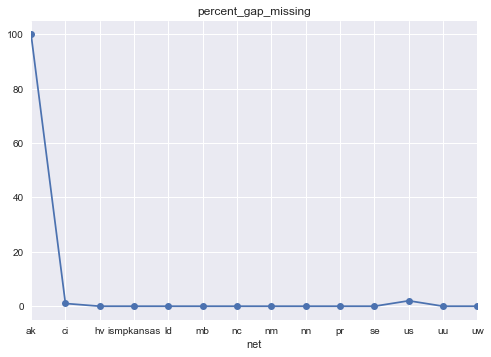

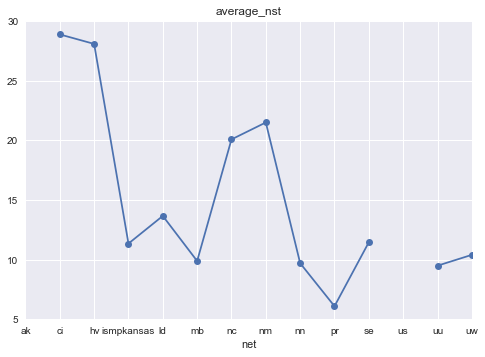

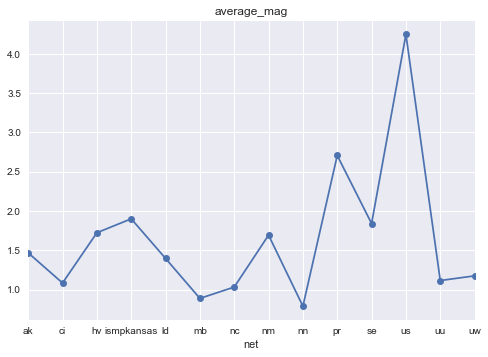

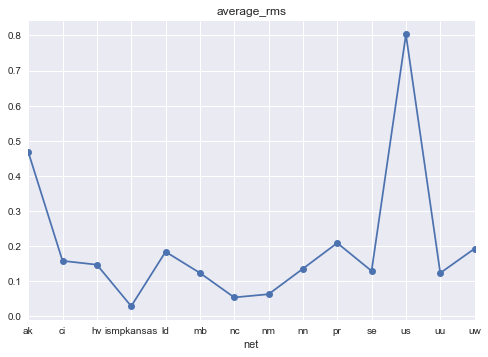

In [21]:
plot_cols = ['percent_gap_missing', 'average_nst', 'average_mag', 'average_rms']
for col in plot_cols:
    dfn[col].plot(kind='line', marker='o')
    plt.title(col)
    plt.xticks([x for x in range(len(dfn.index))], dfn.index.values)
    plt.show()

### Adding Network Average RMS
Let's add the average network RMS back to the original dataframe by merging tables dfn (the table with network info) and df (the original EQ catalog). We will then calculate a new column that shows each EQs deviation from its network's average RMS. 

In [22]:
df_new = df.merge(dfn[['average_rms']], left_on='net', right_index=True)
print(df_new[['net', 'average_rms']])

             net  average_rms
0             ak     0.468384
1             ak     0.468384
3             ak     0.468384
4             ak     0.468384
9             ak     0.468384
10            ak     0.468384
14            ak     0.468384
16            ak     0.468384
18            ak     0.468384
20            ak     0.468384
21            ak     0.468384
24            ak     0.468384
27            ak     0.468384
29            ak     0.468384
33            ak     0.468384
38            ak     0.468384
43            ak     0.468384
47            ak     0.468384
48            ak     0.468384
53            ak     0.468384
54            ak     0.468384
55            ak     0.468384
60            ak     0.468384
66            ak     0.468384
69            ak     0.468384
71            ak     0.468384
75            ak     0.468384
89            ak     0.468384
90            ak     0.468384
103           ak     0.468384
...          ...          ...
2517  ismpkansas     0.028000
2784  ismp

In [23]:
df_new['deviation_network_average'] = df_new.rms - df_new.average_rms
print(df_new)

                          time   latitude   longitude   depth   mag magType  \
0     2017-04-16T01:47:11.617Z  63.149600 -149.702500   86.10  2.30      ml   
1     2017-04-16T01:35:48.014Z  60.157100 -150.979100   34.10  2.20      ml   
3     2017-04-16T00:43:15.866Z  60.108400 -153.022300  122.80  2.50      ml   
4     2017-04-16T00:31:56.662Z  62.097700 -150.062000   79.60  1.20      ml   
9     2017-04-16T00:26:34.612Z  61.720800 -148.065300    1.40  1.90      ml   
10    2017-04-16T00:11:27.208Z  62.354200 -149.140300    0.00  1.30      ml   
14    2017-04-15T23:39:47.685Z  61.718100 -150.248600   19.80  1.30      ml   
16    2017-04-15T23:30:38.544Z  53.715700 -163.864300   24.20  2.40      ml   
18    2017-04-15T23:23:37.697Z  60.633900 -149.466200   14.60  1.50      ml   
20    2017-04-15T23:00:02.694Z  64.937900 -149.111000    7.40  1.10      ml   
21    2017-04-15T22:51:07.404Z  64.907400 -149.177800   13.20  0.30      ml   
24    2017-04-15T22:05:08.918Z  61.430700 -152.30800

### Distinct Tables
Now let's get a table that drops all rows that have duplicate values in a column we select.

In [24]:
new_cols = ['locationSource', 'average_rms']
print(df_new[new_cols].drop_duplicates(subset=new_cols))

     locationSource  average_rms
0                ak     0.468384
2                ci     0.157369
8                nn     0.134921
11               us     0.803101
52               uw     0.803101
997             guc     0.803101
1409            tul     0.803101
1660            ott     0.803101
1693             ak     0.803101
7276           ismp     0.803101
15               nc     0.053092
19               hv     0.146415
23               pr     0.208320
46               uw     0.192206
168              mb     0.122944
390              uu     0.122689
1043             se     0.128462
1061           ismp     0.028000
1435             ld     0.183333
1568             nm     0.062222


### Selecting Columns with Values in Sequence
We may want to use the new dataframe but only look at a few networks (say uu, uw, and mb). We could do this in at least two ways:

In [25]:
# The long way
con1 = df_new.net == 'uu'
con2 = df_new.net == 'uw'
con3 = df_new.net == 'mb'
df1 = df_new[con1 | con2 | con3]
# the better way
df2 = df_new[df_new.net.isin('uu uw mb'.split())]
# make sure all values are equal
assert df1.equals(df2)